# Deep Neural Network with Bells & Whistles

This is a complete example of building a deep neural network with implementations of forward and backward propgation.
The implementation does not use any frameworks like TensorFlow.
It is just plain Python implementations of all the components of a DNN
Other elements such as regularization, initialization, normalization, and using momentum etc. have all been incorporated as well. 

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward

%pip install matplotlib
%pip install ipympl
%matplotlib inline

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#
# Perform randomized initialization of weights & bias parameters
# The choice of initialization method could be "He", "Xavier" or none
#
def initialize_parameters_momentum_rmsprop(layer_dims, method="he"):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    momentum = {}
    rmsprop = {}
    
    # total number of layers in the network, including the input layer
    L = len(layer_dims)            

    #
    # Initialize the matrix comprising weights (W) and bias values (b) for each layer.
    # Note that the input layer does not count as a hidden layer
    # Employ a specified initialization which uses a scaling factor based on the number of units in the previous layer
    # n_h(i) represents the number of units in hidden layer i
    # Dimension of W matrix for layer i = n_h(i) x n_h(i-1), where n_h(i) represents the number of units in hidden layer i
    # Dimension of b vector for layer i = n_h(i);
    #
    print ("Initializing parameters with '{}' method".format(method))
    for l in range(1, L):
        layer_dims_current = layer_dims[l] 
        layer_dims_previous = layer_dims[l-1]
        
        scaling_factor = 0.01
        if method == "he":
            scaling_factor = np.sqrt(2.0/layer_dims_previous)
        elif method == "xavier":
            scaling_factor = np.sqrt(1.0/layer_dims_previous)
        
        parameters["W" + str(l)] = np.random.randn (layer_dims_current, layer_dims_previous) * scaling_factor;
        parameters["b" + str(l)] = np.zeros ((layer_dims_current, 1));
        
        momentum["vdW" + str(l)] = np.zeros ((layer_dims_current, layer_dims_previous));
        momentum["vdb" + str(l)] = np.zeros ((layer_dims_current, 1));
        
        rmsprop["sdW" + str(l)] = np.zeros ((layer_dims_current, layer_dims_previous));
        rmsprop["sdb" + str(l)] = np.zeros ((layer_dims_current, 1));        
        
        assert(parameters["W" + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layer_dims[l], 1))
        
    return parameters, momentum, rmsprop

In [4]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    parameter_cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass 
    """
    #
    # The output for a given layer are computed using the weights/bias parameters for that layer 
    # and the activation of the previous layer
    #
    Z = np.matmul (W, A) + b;
    assert(Z.shape == (W.shape[0], A.shape[1]))
    parameter_cache = (A, W, b)
    return Z, parameter_cache;

In [5]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    all_cache -- a python dictionary containing "parameter_cache" and "output_cache";
             stored for computing the backward pass efficiently
    """
    
    #
    # First, compute the output for a given layer using forward propagation step.
    # Then, compute the activation for that layer using either sigmoid or RelU function
    # Store the weights W & B, activation and the output for the layer in a cache
    # Inputs: "A_prev, W, b". 
    # Outputs: "A, output_cache".
    #
    if activation == "sigmoid":
        Z, parameter_cache = linear_forward(A_prev, W, b)
        A, output_cache = sigmoid(Z);
    elif activation == "relu":
        Z, parameter_cache = linear_forward(A_prev, W, b);
        A, output_cache = relu(Z);
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    all_cache = (parameter_cache, output_cache)

    return A, all_cache

In [6]:
def L_model_forward(X, nlayers, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    all_caches = []
    A = X
    L = nlayers
    
    #
    # Go through each hidden layer and perform linear propagation
    # Note that for all hidden layers, we are using RelU function to compute the activation
    # As we are doing binary classification, we are using sigmoid activation for the final layer  
    # Cache the results from each layer
    #
    AL = None;
    for l in range(1, L+1):
        A_prev = A;
        W = parameters["W" + str(l)];
        b = parameters["b" + str(l)];
        
        if (l == L):
            AL, all_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid");
        else:
            A, all_cache = linear_activation_forward(A_prev, W, b, activation = "relu");
        
        all_caches.append(all_cache);
    
    assert(AL.shape == (1,X.shape[1]))
    return AL, all_caches

In [7]:
def compute_cost(AL, Y):
    """
    Implement the cross-entropy cost function

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    logprobs = np.multiply (Y, np.log(AL)) + np.multiply ((1-Y), np.log(1-AL));
    cost = - np.sum(logprobs)/m;  
    
    # Cost is a scalar value
    # Use np.squeeze which removes single-dimensional entries from the shape of an array.
    cost = np.squeeze(cost)     
    assert(cost.shape == ())
    return cost

In [8]:
def compute_cost_with_regularization(AL, Y, nlayers, parameters, lambd):
    """
    Implement the cost function with L2 regularization. 
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    L = nlayers 
    m = Y.shape[1]
    
    cross_entropy_cost = compute_cost(AL, Y) 
    
    L2_regularization_cost = 0.0
    for l in range(1, L+1):
        W = parameters['W' + str(l)];
        L2_regularization_cost = L2_regularization_cost + (np.sum(np.square(W)))
    
    L2_regularization_cost = lambd * L2_regularization_cost / (2*m);
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [9]:
def linear_backward(dZ, parameter_cache, lambd = 0.0):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = parameter_cache;
    m = A_prev.shape[1];

    dW = np.matmul (dZ, A_prev.T)/m + (lambd/m) * W;
    db = np.sum(dZ, axis=1, keepdims=True)/m;
    dA_prev = np.matmul (W.T, dZ);
    
    assert (dA_prev.shape == A_prev.shape);
    assert (dW.shape == W.shape);
    assert (db.shape == b.shape);
    
    return dA_prev, dW, db

In [10]:
def linear_activation_backward(dA, all_cache, activation, lambd = 0.0):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    parameter_cache, output_cache = all_cache
    
    dZ = None;
    if activation == "relu":
        dZ = relu_backward (dA, output_cache);
    elif activation == "sigmoid":
        dZ = sigmoid_backward (dA, output_cache);        
        
    dA_prev, dW, db = linear_backward(dZ, parameter_cache, lambd);     
    return dA_prev, dW, db

In [11]:
def L_model_backward(AL, Y, nlayers, all_caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    gradients -- A dictionary with the gradients
             gradients["dA" + str(l)] = ... 
             gradients["dW" + str(l)] = ...
             grgradientsads["db" + str(l)] = ... 
    """
    gradients = {}
    L = nlayers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    #
    # First, compute the change in cost function due to changes in the input to the last layer => dZL
    # Next, compute dAL which is what we need to get started with back propagation.
    #
    dZL = AL - Y;
    dAL = np.divide (dZL, np.multiply(AL, (1 - AL)));
    
    #
    # Lth hidden layer (SIGMOID -> LINEAR) gradients. 
    # Inputs: "dAL, current_cache". 
    # Outputs: "gradients["dAL-1"], gradients["dWL"], gradients["dbL"]
    #
    current_cache = all_caches[L-1];
    dA = dAL
    gradients ["dA" + str(L-1)], \
    gradients ["dW" + str(L)], \
    gradients ["db" + str(L)] = linear_activation_backward(dA, current_cache, "sigmoid");
    
    #
    # From the (L-1)th layer until the input layer,all layers are using RelU activation
    # Hence, we can implement linear-activation backward step for these layers in a loop
    #
    for l in reversed(range(L-1)):
        #
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "gradients["dA" + str(l + 1)], current_cache". 
        # Outputs: "gradients["dA" + str(l)], gradients["dW" + str(l + 1)], gradients["db" + str(l + 1)] 
        #
        current_cache = all_caches[l];
        dA = gradients["dA" + str(l + 1)];
        gradients["dA" + str(l)], \
        gradients["dW" + str(l + 1)], \
        gradients["db" + str(l + 1)] = linear_activation_backward(dA, current_cache, "relu");

    return gradients

In [12]:
def update_parameters_adam (nlayers, parameters, gradients, momentum, rmsprop,
                            t, learning_rate, beta1, beta2, lambd, m):
    L = nlayers 
    decay_factor = 1 - (learning_rate*lambd/m);
    epsilon = 1.0e-08
    bias_correction = t;
    
    for l in range(1,L+1):
        # Retrieve W & b from the dictionary "parameters"
        W = parameters["W" + str(l)];
        b = parameters["b" + str(l)];
        
        # Retrieve dW & db from the dictionary "gradients"
        dW = gradients["dW" + str(l)];
        db = gradients["db" + str(l)];
        
        # Retrieve vdW & vdb from the dictionary "momentum"
        vdW = momentum["vdW" + str(l)];
        vdb = momentum["vdb" + str(l)];        
        
        # Retrieve sdW & sdb from the dictionary "rmsprop"
        sdW = rmsprop["sdW" + str(l)];
        sdb = rmsprop["sdb" + str(l)];   
        
        # Compute the new momentum terms
        vdW = beta1 * vdW + (1 - beta1) * dW
        vdb = beta1 * vdb + (1 - beta1) * db
        vdW_corrected = vdW/(1 - beta1**bias_correction);
        vdb_corrected = vdb/(1 - beta1**bias_correction);
        
        # Compute the new rmsprop terms
        sdW = beta2 * sdW + (1 - beta2) * np.multiply(dW,dW)
        sdb = beta2 * sdb + (1 - beta2) * np.multiply(db,db)
        sdW_corrected = sdW/(1 - beta2**bias_correction);
        sdb_corrected = sdb/(1 - beta2**bias_correction);

        #
        # Update rule for each parameter
        # Notice how regularization factors into the updates as a decay parameter, de-emphasizing the values of W & b.
        # Notice how momentum & rmsprop factors into the updates by using the exponential averages of gradients vdW/sdW & vdb/sdb instead of dW & db
        #
        W = decay_factor * W - learning_rate * vdW_corrected/np.sqrt(sdW_corrected + epsilon);
        b = decay_factor * b - learning_rate * vdb_corrected/np.sqrt(sdb_corrected + epsilon);
    
        parameters["W" + str(l)] = W
        parameters["b" + str(l)] = b
        
        momentum["vdW" + str(l)] = vdW
        momentum["vdb" + str(l)] = vdb
        
        rmsprop["sdW" + str(l)] = sdW
        rmsprop["sdb" + str(l)] = sdb        
                
    return parameters, momentum, rmsprop

In [13]:
def update_parameters (nlayers, parameters, gradients, learning_rate, lambd, m):
    L = nlayers 
    decay_factor = 1 - (learning_rate*lambd/m);
    
    for l in range(1,L+1):
        # Retrieve W & b from the dictionary "parameters"
        W = parameters["W" + str(l)];
        b = parameters["b" + str(l)];
        
        # Retrieve dW & db from the dictionary "gradients"
        dW = gradients["dW" + str(l)];
        db = gradients["db" + str(l)];
        
        #
        # Update rule for each parameter
        # Notice how regularization factors into the updates as a decay parameter, de-emphasizing the values of W & b.
        #
        W = decay_factor * W - learning_rate * dW
        b = decay_factor * b - learning_rate * db
    
        parameters["W" + str(l)] = W
        parameters["b" + str(l)] = b
                
    return parameters

In [14]:
def L_layer_model(X, Y, 
                  layers_dims, num_iterations = 2501,
                  learning_rate = 0.0075, beta1 = 0.9, beta2 = 0.999, lambd = 1000.,              
                  init_method = "he",
                  print_cost = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of features, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []        
    m = Y.shape[1]
    t = 0                            
       
    #
    # Parameters initialization.
    # Pay attention to how the parameters are initialized. This has a BIG effect on how the model performs.
    # We have to randomize the parameter values across different layers and not choose the same values for all layers
    #
    parameters, momentum, rmsprop = initialize_parameters_momentum_rmsprop (layers_dims, method=init_method);
    
    #
    # Gradient Descent Loop
    #
    for i in range(0, num_iterations):

        # Increment a separate counter for Adam to handle mini-batch which will have an outer loop
        t = t + 1
        
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, all_caches = L_model_forward(X, nlayers, parameters);
        
        # Compute cost.
        cost = compute_cost_with_regularization(AL, Y, nlayers, parameters, lambd)
    
        # Backward propagation.
        gradients = L_model_backward(AL, Y, nlayers, all_caches);
 
        # Update parameters.
        #parameters = update_parameters (nlayers, parameters, gradients, learning_rate, lambd, m)
        parameters, momentum, rmsprop = update_parameters_adam (nlayers, parameters, gradients, momentum, rmsprop,
                                                                t, learning_rate, beta1, beta2, lambd, m)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    #
    # plot the cost
    #
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [16]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [17]:
def normalize_features(X):
    mu = np.mean(X, axis=0)                 
    sigma  = np.std(X, axis=0)                  
    X_norm = (X - mu) / sigma      
    return (X_norm, mu, sigma)

In [18]:
#
# Read the original dataset
#
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset();
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print ("Training set size = " + str(m_train))
print ("Training set shape = " + str(train_set_x_orig.shape));
print ("Height/Width of each image = " + str(num_px))
print ("Test set size = " + str(m_test))
print ("Number of labels = " + str(train_set_y.shape));
print (train_set_x_orig.shape);

Training set size = 209
Training set shape = (209, 64, 64, 3)
Height/Width of each image = 64
Test set size = 50
Number of labels = (1, 209)
(209, 64, 64, 3)


In [19]:
#
# Flatten the data so that each (num_px, num_px, 3) image is represented numpy-array of shape (num_px * num_px * 3, 1) 
#
train_set_x_flatten= np.reshape (train_set_x_orig, (m_train,-1), "C")
test_set_x_flatten= np.reshape (test_set_x_orig, (m_test,-1), "C")
m_train = train_set_x_flatten.shape[0]
m_test = test_set_x_flatten.shape[0]
n_features = train_set_x_flatten.shape[1]
print ("Flattened Training set size = " + str(m_train))
print ("Flattened Training set shape = " + str(train_set_x_flatten.shape));
print ("Flattened Test set size = " + str(m_test))
print ("Number of features = " + str(n_features))
print (train_set_x_flatten.shape);

Flattened Training set size = 209
Flattened Training set shape = (209, 12288)
Flattened Test set size = 50
Number of features = 12288
(209, 12288)


In [20]:
#
# Normalize the training and test data
# After normalization, the mean value in each feature should be close to 0 and variance should be close to 1
# Without normalization, Gradient Descent diverges right away for the same hyperparameters for this use case.
#
max_mu = np.max(np.mean(train_set_x_flatten, axis=0), axis=0)
max_std = np.max(np.std(train_set_x_flatten, axis=0), axis=0)
print ("Maximum mean & std in training set = {} and {}".format (max_mu, max_std));

train_set_x_norm, train_mu, train_sigma = normalize_features(train_set_x_flatten) 

max_mu = np.max(np.mean(train_set_x_norm, axis=0), axis=0)
max_std = np.max(np.std(train_set_x_norm, axis=0), axis=0)
print ("Maximum mean & std in training set after normalization = {} and {}".format (max_mu, max_std));

#
# It is important to normalize the test data using the same mean & variance value used for training set
#
test_set_x_norm = (test_set_x_flatten - train_mu)/train_sigma

#
# Constants defining the number of layers in the model
# Note that the number of units in the first layer must be equal to the number of features in a training sample
# The first layer is not counted as a hidden layer. 
# Weights & parameters are computed only for the hidden layers.
#
layers_dims = [12288, 20, 7, 5, 1] 
nlayers = len(layers_dims)-1

Maximum mean & std in training set = 134.2153110047847 and 81.44342276651373
Maximum mean & std in training set after normalization = 2.407696583307905e-16 and 1.000000000000001


Initializing parameters with 'he' method
Cost after iteration 0: 1.8495063747767715
Cost after iteration 100: 0.5101219913122284
Cost after iteration 200: 0.47433306464841507
Cost after iteration 300: 0.4098983036881122
Cost after iteration 400: 0.36462625553353895
Cost after iteration 500: 0.3358929083921332
Cost after iteration 600: 0.31944958957158026
Cost after iteration 700: 0.31137654877909626
Cost after iteration 800: 0.30792835465114415
Cost after iteration 900: 0.30665962836655053
Cost after iteration 1000: 0.30623013267746413
Cost after iteration 1100: 0.3061114012943544
Cost after iteration 1200: 0.30606824712637754
Cost after iteration 1300: 0.3060562548089629
Cost after iteration 1400: 0.3060555461846977
Cost after iteration 1500: 0.30605261852091187
Cost after iteration 1600: 0.30605367704428876
Cost after iteration 1700: 0.3060530695107565
Cost after iteration 1800: 0.30605397659203715
Cost after iteration 1900: 0.30605315975683783
Cost after iteration 2000: 0.3060836553

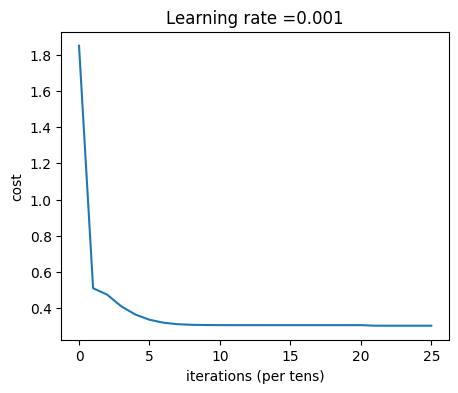

In [22]:
parameters = L_layer_model(train_set_x_norm.T, \
                           train_set_y, \
                           layers_dims, num_iterations = 2501, \
                           learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999, lambd = 0.01, \
                           init_method = "he", print_cost = True)

In [41]:
def predict(X, Y, nlayers, parameters):
    m = X.shape[1]
    probabilities, caches = L_model_forward(X, nlayers, parameters)
    predictions = (probabilities > 0.5).astype(int)
    print("Accuracy: " + str(np.sum((predictions == Y)/m)))
    return predictions

In [42]:
train_predictions = predict(train_set_x_norm.T, train_set_y, nlayers, parameters)
train_predictions = predict(test_set_x_norm.T, test_set_y, nlayers, parameters)

Accuracy: 0.894736842105
Accuracy: 0.7
